# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [2]:
# < ENTER YOUR CODE HERE > 
data0 = pd.read_csv('adult_data_train.csv', sep=',')
data0.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,7298,0,50,United-States,1
6,44,Private,310255,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,1
7,53,Private,121441,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,0
8,44,Self-emp-inc,191712,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,55,United-States,1
9,28,?,149646,Some-college,10,Divorced,?,Own-child,White,Female,0,0,20,?,0


In [3]:
data = data0.loc[:, ~data0.columns.isin(['education', 'marital-status'])]
data.head(10)

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,9,Tech-support,Husband,White,Male,7298,0,50,United-States,1
6,44,Private,310255,10,Craft-repair,Husband,White,Male,0,0,60,United-States,1
7,53,Private,121441,10,Sales,Husband,White,Male,0,0,55,United-States,0
8,44,Self-emp-inc,191712,14,Prof-specialty,Husband,White,Male,0,2415,55,United-States,1
9,28,?,149646,10,?,Own-child,White,Female,0,0,20,?,0


Определите количество числовых и нечисловых признаков.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education-num   26048 non-null  int64 
 4   occupation      26048 non-null  object
 5   relationship    26048 non-null  object
 6   race            26048 non-null  object
 7   sex             26048 non-null  object
 8   capital-gain    26048 non-null  int64 
 9   capital-loss    26048 non-null  int64 
 10  hours-per-week  26048 non-null  int64 
 11  native-country  26048 non-null  object
 12  label           26048 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ MB


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

label
0    0.759175
1    0.240825
Name: proportion, dtype: float64

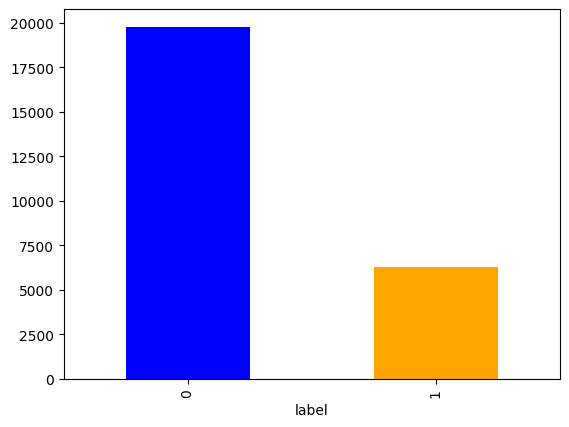

In [5]:
data['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
data['label'].value_counts(normalize='True')

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [6]:
# < ENTER YOUR CODE HERE > 
numerical_data = data.iloc[:, ~data.columns.isin(["workclass","occupation","relationship","race","sex","native-country"]) ]
X, y = numerical_data.iloc[:, numerical_data.columns != "label" ], numerical_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=numerical_data['label'])
X_test.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
24215,38,103408,14,0,0,40
3383,28,25955,11,0,0,40
22462,44,181762,13,15024,0,55
8242,41,406603,9,0,0,6
8816,41,29702,11,0,0,30


In [7]:
X_train.fnlwgt.mean()

190551.5973221998

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
f1_score(knn.predict(X_test), y_test)

0.4036603965429588

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [9]:
# < ENTER YOUR CODE HERE > 
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
X_train.fnlwgt.mean()

0.1419259023276068

In [11]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
f1_score(knn.predict(X_test), y_test)

0.536918869644485

Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

<Axes: xlabel='occupation', ylabel='count'>

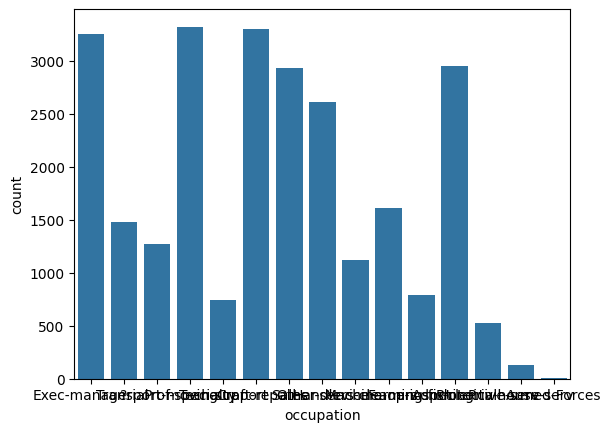

In [12]:
sns.countplot(x='occupation', data=data)

<Axes: xlabel='occupation', ylabel='count'>

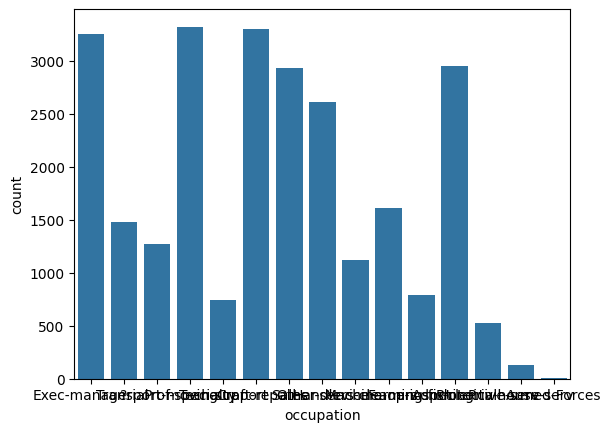

In [13]:
sns.countplot(x='occupation', data=data)

<Axes: xlabel='relationship', ylabel='count'>

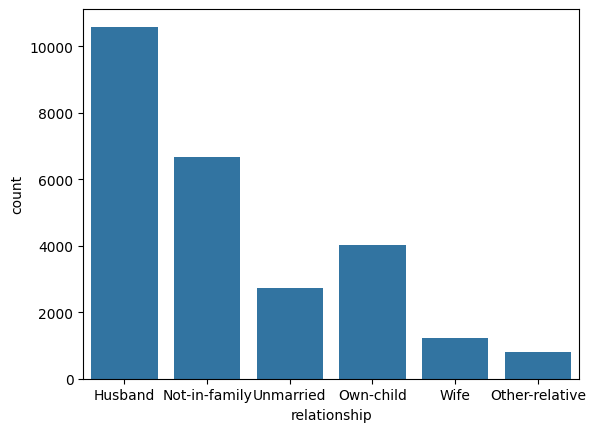

In [14]:
sns.countplot(x='relationship', data=data)

<Axes: xlabel='race', ylabel='count'>

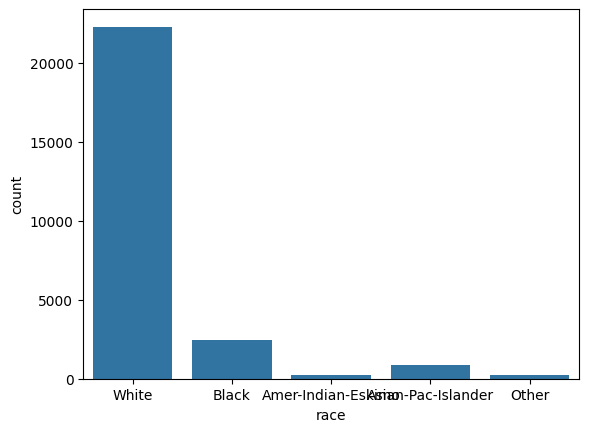

In [15]:
sns.countplot(x='race', data=data)

<Axes: xlabel='sex', ylabel='count'>

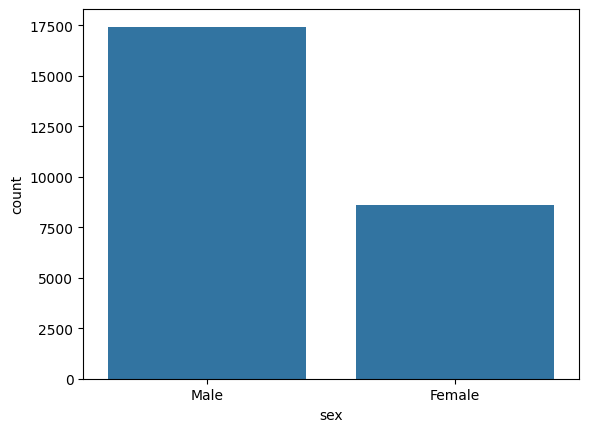

In [16]:
sns.countplot(x='sex', data=data)

<Axes: xlabel='native-country', ylabel='count'>

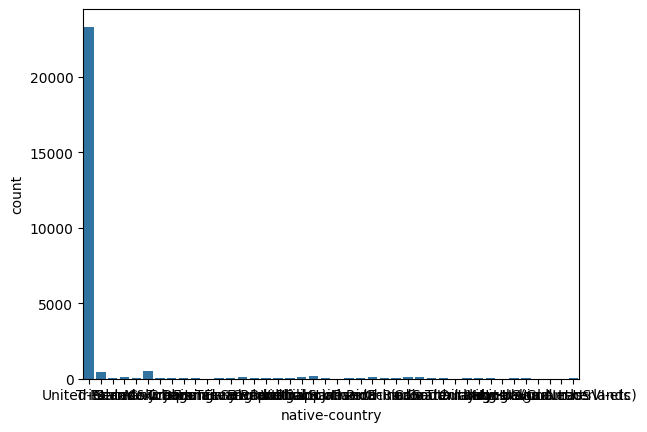

In [17]:
sns.countplot(x='native-country', data=data)

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [18]:
transformed_NaN_data = data.replace("?", pd.NA)

In [19]:
len(transformed_NaN_data[transformed_NaN_data.isna().any(axis=1)])

1914

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [20]:
cleaned_data = transformed_NaN_data[~transformed_NaN_data.isna().any(axis = 1)]

In [21]:
one_hot_cleaned_data = pd.get_dummies(cleaned_data, drop_first=True)
one_hot_cleaned_data.shape[1] - 1

75

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [22]:
X, y = one_hot_cleaned_data.iloc[:, one_hot_cleaned_data.columns != "label" ], one_hot_cleaned_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=one_hot_cleaned_data['label'])

scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
f1_score(knn.predict(X_test), y_test)

0.6228926353149956

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [24]:
#меняем пропуски на NaN
NaN_transformed_data = data.replace('?', pd.NA)
NaN_transformed_data.head()

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,<NA>,122244,9,<NA>,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


In [25]:
filled_data = NaN_transformed_data.apply(lambda x: x.fillna(x.mode()[0]))

Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [26]:
normal_data = pd.get_dummies(filled_data, drop_first='True')

In [27]:
X, y = normal_data.loc[:, normal_data.columns!='label'], normal_data.label

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=normal_data['label'])

In [29]:
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
f1_score(knn.predict(X_test), y_test)

0.6234096692111959

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.